In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from datetime import datetime, timedelta
from itertools import product

import utils

# read csv
bandwidth = pd.read_csv('data/bandwidth.csv')
bandwidth.columns = ['bandwidth']
# input hourly dates starting from 2019/01/01
inital_date = datetime(2000, 1, 1, 0, 0, 0)
hourly_delta = timedelta(hours=1)

hourly_dates = []
for i in range(bandwidth.shape[0]):
    hourly_dates.append((i * hourly_delta) + inital_date)
    
bandwidth['date'] = pd.to_datetime(hourly_dates)
bandwidth.set_index('date', inplace=True)
bandwidth.index.freq = 'H'
bandwidth.head()

,bandwidth
date,
2000-01-01 00:00:00,1000.496714
2000-01-01 01:00:00,1000.969408
2000-01-01 02:00:00,1002.046019
2000-01-01 03:00:00,1004.702118
2000-01-01 04:00:00,1007.447816


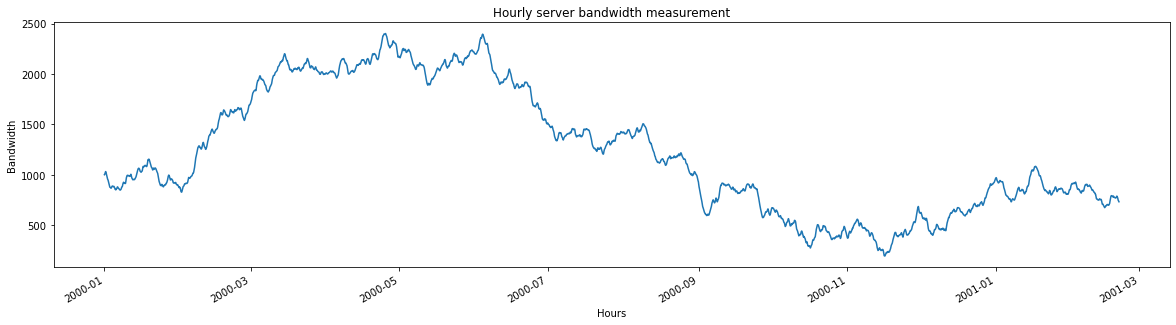

In [2]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(bandwidth['bandwidth'])
ax.set_ylabel('Bandwidth')
ax.set_xlabel('Hours')

plt.title('Hourly server bandwidth measurement')

fig.autofmt_xdate()
plt.show()

### Find the number of differencing need to make for stationarity

In [3]:
d = 0
data_to_test_adf = bandwidth.copy()
while (True):
    adf_test = adfuller(data_to_test_adf['bandwidth'], maxlag=30)
    print(adf_test)
    if adf_test[1] < 0.05:
        break
    else: 
        data_to_test_adf['bandwidth'] = data_to_test_adf['bandwidth'].diff()
        data_to_test_adf.dropna(inplace=True)   
        d = d + 1

del data_to_test_adf
print(d)

(-0.8714653199452932, 0.7972240255014489, 6, 9993, {'1%': -3.431004556246501, '5%': -2.8618292749021865, '10%': -2.5669239758928017}, 28374.468071289302)
(-20.69485386378901, 0.0, 5, 9993, {'1%': -3.431004556246501, '5%': -2.8618292749021865, '10%': -2.5669239758928017}, 28368.019619037077)
1


### Create test and training sets

In [4]:
test_set_size = int(0.1 * bandwidth.shape[0]) # one week worth for forecasting

df = bandwidth.copy()

train = df[:-test_set_size]
test = df[-test_set_size:]

print(len(train))
print(len(test))

9000
1000


### Create the optimize_arima function that returns the arima order and the aic sorted in descending order

In [5]:
optimal_arima_df = utils.optimize_arima(bandwidth['bandwidth'], i=1) # I migrated this implemenation to utils.py
optimal_arima_df.head()

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,aic,sse
14,"(3, 2)",28451.238299,1.011054e+06
11,"(2, 3)",28451.414819,1.011054e+06
10,"(2, 2)",28451.714968,1.011057e+06
15,"(3, 3)",28453.441668,1.011054e+06
7,"(1, 3)",28462.680900,1.011068e+06


### We pick the best performing order and use the order

In [7]:
arima_order = (3, d, 2)
arima_model = ARIMA(bandwidth['bandwidth'], order=arima_order).fit()
res = arima_model.resid
print(arima_model.aic, arima_model.sse)

28451.238298669523 1011054.1581880065


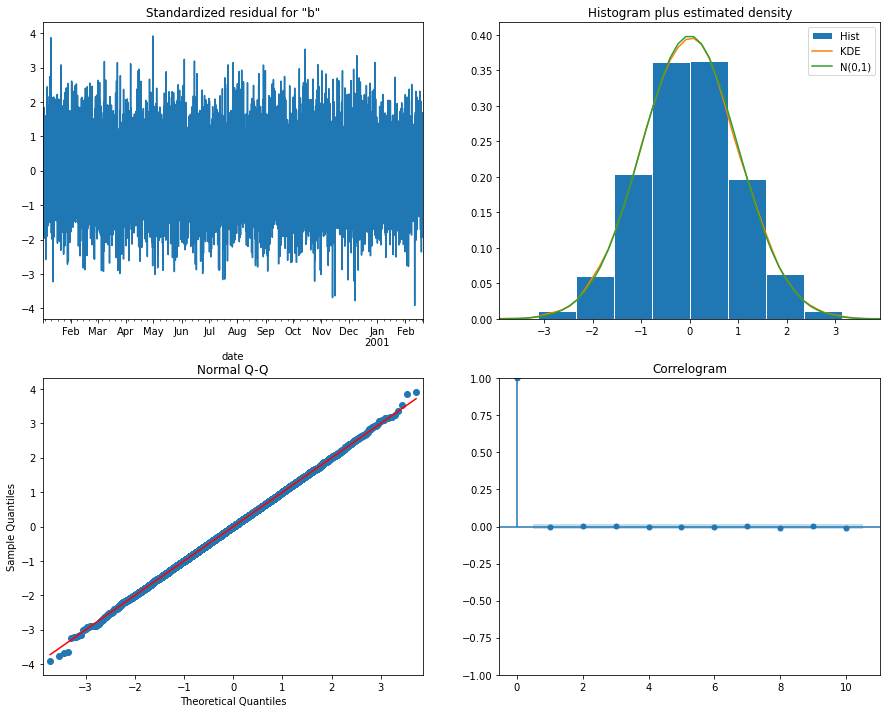

In [8]:
arima_model.plot_diagnostics(figsize=(15, 12));

In [9]:
ljungbox_test_df = acorr_ljungbox(arima_model.resid, np.arange(1, 11, 1))
auto_corr_test = np.sum(ljungbox_test_df.loc[:, 'lb_pvalue'].values < 0.05)
print('Residuals is a white noise' if auto_corr_test == 0 else 'Residuals is autocorrelated')

Residuals is a white noise


### 6.6 Forecasting sales using rolling prediction

In [10]:
def arima_predict_function(arr, arma_order, window):
    arima = ARIMA(arr, order=arma_order)
    fit = arima.fit()
    return fit.get_forecast(steps=window).predicted_mean

total_len = bandwidth.shape[0]
train_len = train.shape[0]
window = 2

test.loc[:, 'predicted_bandwidth'] = utils.pd_rolling_forecast(
    bandwidth['bandwidth'], total_len, train_len, window, 'ARMA', arima_order, arima_predict_function)

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_51844/2941555654.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted_bandwidth'] = utils.pd_rolling_forecast(


In [11]:
test.head()

,bandwidth,predicted_bandwidth
date,,
2001-01-10 00:00:00,848.353097,847.567870
2001-01-10 01:00:00,853.879556,851.047189
2001-01-10 02:00:00,859.662415,859.137953
2001-01-10 03:00:00,863.162335,863.904793
2001-01-10 04:00:00,865.454674,865.641279


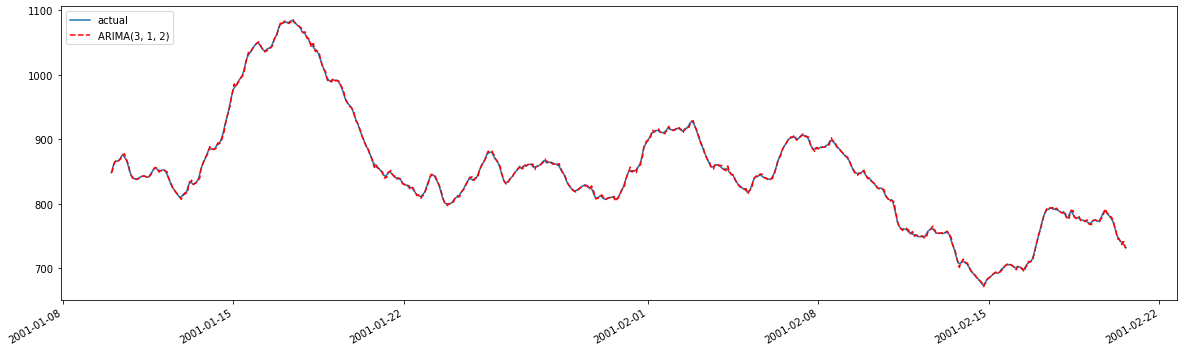

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test.bandwidth, label='actual')
ax.plot(test.predicted_bandwidth, 'r--', label=f'ARIMA{arima_order}')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.show()

In [17]:
mse_arima = mean_squared_error(test['bandwidth'], test['predicted_bandwidth'])
print(mse_arima)

3.361234176513718


In [18]:
mae_arima = mean_absolute_error(test['bandwidth'], test['predicted_bandwidth'])
print(mae_arima)

1.341606428126208
